# Informações gerais

Esse notebook objetiva comparar a performance de diferentes algoritmos de alocação e roteamento em comparação com o RSA e SAR.

Todas as simulações estão na Carga de 300 Erlangs

## Importando todos os pacotes e funções necessárias

In [1]:
# Printa a versão do Python
import sys
print(f"Versão do Python: {sys.version}")

Versão do Python: 3.11.7 (tags/v3.11.7:fa7a6f2, Dec  4 2023, 19:24:49) [MSC v.1937 64 bit (AMD64)]


In [2]:
# Importa as bibliotecas
import os
import pickle

import numpy as np
import pandas as pd

import torch as th

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

%matplotlib inline

In [3]:
from Enviroment.Settings import *
from Enviroment.Manager import Enviroment

In [4]:
from stable_baselines3 import PPO

In [5]:
def run_test(env, model, num_sim=10, main_seed=42):
    """ Realiza a simulação do modelo em um ambiente de simulação e retorna as probabilidades de bloqueio e as recompensas médias.

    Args:
        env (Enviroment): Ambiente de simulação.
        model (Model): Modelo a ser testado.
        num_sim (int): Número de simulações a serem realizadas.

    Returns:
        pbs (np.array): Probabilidades de bloqueio.
        reward (np.array): Recompensas médias.
    """

    number_of_nodes = env._number_of_nodes

    # Verifica se model é uma string com o nome do modelo
    if isinstance(model, str):
        if model not in ['RSA', 'SAR']:
            raise ValueError("Model must be 'RSA', 'SAR', a trained model from Stable Baselines 3 or a numpy array with the size equal to the number of nodes squared.")
    else:
        if not hasattr(model, 'predict') and not isinstance(model, np.ndarray) and model.shape != (number_of_nodes**2,):
            raise ValueError("Model must be 'RSA', 'SAR', a trained model from Stable Baselines 3 or a numpy array with the size equal to the number of nodes squared.")
    
    if isinstance(model, str):
        if model == 'RSA':
            print("Executando a avaliação do RSA")
        elif model == 'SAR':
            print("Executando a avaliação do SAR")
    elif isinstance(model, np.ndarray):
        print("Executando a avaliação do GA")
    else:
        print("Executando a avaliação do modelo")

    # Reseta a seed para garantir a reprodutibilidade dos resultados
    np.random.seed(main_seed)

    # Gera uma seed para cada simulação
    seeds = np.random.randint(0, 100_000, num_sim, dtype=int)

    # Cria um array para armazenar as probabilidades de bloqueio e as recompensas de cada simulação
    pbs = np.zeros(num_sim)
    rewards = np.zeros(num_sim)

    RSA_SAR_count = [0, 0]

    # Executa as simulações
    for i, seed in enumerate(seeds):

        print(f"Executando simulação {i+1} de {num_sim} com seed {seed}.")

        # Reseta o ambiente para garantir que ele esteja no estado inicial usando a seed
        state, info = env.reset(int(seed))

        # Executa a simulação
        while True:

            if isinstance(model, str):
                if model == 'RSA':
                    alg_heuristic = 0
                elif model == 'SAR':
                    alg_heuristic = 1
            elif isinstance(model, np.ndarray):
                alg_heuristic = model[state[1] + state[0] * 14]
            else:
                alg_heuristic = model.predict(observation=state, deterministic=True)[0]

            RSA_SAR_count[alg_heuristic] += 1

            state, _, done, trunk, info = env.step(alg_heuristic)

            if (done or trunk) and rewards[i] == 0:
                rewards[i] = env._reward_episode
                break

        pbs[i] = info['total_number_of_blocks'] / info['last_request']

        print(f"Blocking Probability: {pbs[i]} | Reward: {rewards[i]} | Req: {info['last_request']}")

    print(f"\nBlocking Probability: {np.mean(pbs)} | Min: {np.min(pbs)} | Max: {np.max(pbs)} | +- {np.std(pbs)}")
    print(f"Reward: {np.mean(rewards)} | Min: {np.min(rewards)} | Max: {np.max(rewards)} | +- {np.std(rewards)}")
    print(f"RSA count: {RSA_SAR_count[0]} ({RSA_SAR_count[0]/(RSA_SAR_count[0]+RSA_SAR_count[1]):.2%}) | SAR count: {RSA_SAR_count[1]} ({RSA_SAR_count[1]/(RSA_SAR_count[0]+RSA_SAR_count[1]):.2%})")

    return {
        'pbs': pbs,
        'rewards': rewards,
        'RSA_SAR_count': RSA_SAR_count
    }

# Avaliando os modelos

In [6]:
# Avaliando a PB do modelo treinado
enviroment_type_test = {
    "Observation": "OD",
    "Action": "RSA-SAR",
    "Reward": "RL-defaut",
    "StopCond": "MaxReq",
    "StartCond": "Empty"
}

In [7]:
results_models_300e = {}

## Modelo RSA

In [8]:
# Cria o ambiente de simulação
env = Enviroment(
    network_load=300,
    k_routes=K_ROUTES,
    number_of_slots=NUMBER_OF_SLOTS,
    enviroment_type=enviroment_type_test,
    data_folder="Evaluation_RSA_300e",
)

results_models_300e['RSA'] = run_test(env, 'RSA', num_sim=30, main_seed=123)

Executando a avaliação do RSA
Executando simulação 1 de 30 com seed 15725.
Blocking Probability: 0.01455 | Reward: 97090.0 | Req: 100000
Executando simulação 2 de 30 com seed 28030.
Blocking Probability: 0.01504 | Reward: 96992.0 | Req: 100000
Executando simulação 3 de 30 com seed 17730.
Blocking Probability: 0.01585 | Reward: 96830.0 | Req: 100000
Executando simulação 4 de 30 com seed 61404.
Blocking Probability: 0.01582 | Reward: 96836.0 | Req: 100000
Executando simulação 5 de 30 com seed 63206.
Blocking Probability: 0.01466 | Reward: 97068.0 | Req: 100000
Executando simulação 6 de 30 com seed 15377.
Blocking Probability: 0.01568 | Reward: 96864.0 | Req: 100000
Executando simulação 7 de 30 com seed 73299.
Blocking Probability: 0.0142 | Reward: 97160.0 | Req: 100000
Executando simulação 8 de 30 com seed 46203.
Blocking Probability: 0.01434 | Reward: 97132.0 | Req: 100000
Executando simulação 9 de 30 com seed 89302.
Blocking Probability: 0.01617 | Reward: 96766.0 | Req: 100000
Executan

## Modelo SAR

In [9]:
# Cria o ambiente de simulação
env = Enviroment(
    network_load=300,
    k_routes=K_ROUTES,
    number_of_slots=NUMBER_OF_SLOTS,
    enviroment_type=enviroment_type_test,
    data_folder="Evaluation_SAR_300e",
)

results_models_300e['SAR'] = run_test(env, 'SAR', num_sim=30, main_seed=123)

Executando a avaliação do SAR
Executando simulação 1 de 30 com seed 15725.
Blocking Probability: 0.01223 | Reward: 97554.0 | Req: 100000
Executando simulação 2 de 30 com seed 28030.
Blocking Probability: 0.01234 | Reward: 97532.0 | Req: 100000
Executando simulação 3 de 30 com seed 17730.
Blocking Probability: 0.01261 | Reward: 97478.0 | Req: 100000
Executando simulação 4 de 30 com seed 61404.
Blocking Probability: 0.01237 | Reward: 97526.0 | Req: 100000
Executando simulação 5 de 30 com seed 63206.
Blocking Probability: 0.01223 | Reward: 97554.0 | Req: 100000
Executando simulação 6 de 30 com seed 15377.
Blocking Probability: 0.01234 | Reward: 97532.0 | Req: 100000
Executando simulação 7 de 30 com seed 73299.
Blocking Probability: 0.01083 | Reward: 97834.0 | Req: 100000
Executando simulação 8 de 30 com seed 46203.
Blocking Probability: 0.01093 | Reward: 97814.0 | Req: 100000
Executando simulação 9 de 30 com seed 89302.
Blocking Probability: 0.0126 | Reward: 97480.0 | Req: 100000
Executan

## Modelo Híbrido com GA

O GA foi treinado de forma simplificado. Com algumas alterações é possível treinar o GA para encontrar a melhor solução para o problema.

In [10]:
chromossome_solution = np.array([0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1,])

# Cria o ambiente de simulação
env = Enviroment(
    network_load=300,
    k_routes=K_ROUTES,
    number_of_slots=NUMBER_OF_SLOTS,
    enviroment_type=enviroment_type_test,
    data_folder="Evaluation_GA_300e",
)

results_models_300e['GA'] = run_test(env, chromossome_solution, num_sim=30, main_seed=123)

Executando a avaliação do GA
Executando simulação 1 de 30 com seed 15725.
Blocking Probability: 0.01004 | Reward: 97992.0 | Req: 100000
Executando simulação 2 de 30 com seed 28030.
Blocking Probability: 0.01001 | Reward: 97998.0 | Req: 100000
Executando simulação 3 de 30 com seed 17730.
Blocking Probability: 0.01103 | Reward: 97794.0 | Req: 100000
Executando simulação 4 de 30 com seed 61404.
Blocking Probability: 0.0101 | Reward: 97980.0 | Req: 100000
Executando simulação 5 de 30 com seed 63206.
Blocking Probability: 0.01062 | Reward: 97876.0 | Req: 100000
Executando simulação 6 de 30 com seed 15377.
Blocking Probability: 0.01007 | Reward: 97986.0 | Req: 100000
Executando simulação 7 de 30 com seed 73299.
Blocking Probability: 0.00926 | Reward: 98148.0 | Req: 100000
Executando simulação 8 de 30 com seed 46203.
Blocking Probability: 0.00902 | Reward: 98196.0 | Req: 100000
Executando simulação 9 de 30 com seed 89302.
Blocking Probability: 0.01077 | Reward: 97846.0 | Req: 100000
Executand

# Comparando os modelos

In [47]:
def include_models(models_results):
    
    # Cria um boxplot com as probabilidades de bloqueio no gráfico da esquerda e um boxplot com as recompensas no gráfico da direita para cada modelo
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # Cria a lista com o nome dos modelos
    data_name = []
    # Cria a lista com as probabilidades de bloqueio
    data_PB = []
    # Cria a lista com as recompensas
    data_rewards = []

    data_RSA_SAR_count = []

    for model_name, model_data in models_results.items():

        data_name.append(model_name)

        data_PB.append(model_data["pbs"])

        data_rewards.append(model_data["rewards"])

        data_RSA_SAR_count.append(model_data["RSA_SAR_count"])

    # Boxplot das probabilidades de bloqueio em escala logarítmica
    sns.boxplot(data=data_PB, ax=axs[0])
    axs[0].set_yscale("log")

    axs[0].set_title("Blocking Probability")

    axs[0].xaxis.set_major_locator(ticker.FixedLocator(range(len(data_name))))  # Set fixed locations for ticks
    axs[0].set_xticklabels(data_name)

    axs[0].set_ylabel("Blocking Probability")
    axs[0].grid(axis="y", which="both", linestyle="--", linewidth=0.7)


    sns.boxplot(data=data_rewards, ax=axs[1])

    axs[1].set_title("Rewards")

    axs[1].xaxis.set_major_locator(ticker.FixedLocator(range(len(data_name))))  # Set fixed locations for ticks
    axs[1].set_xticklabels(data_name)
    axs[1].set_ylabel("Rewards")

    axs[1].grid(axis="y", which="both", linestyle="--", linewidth=0.7)

    # Gráfico com a contagem de RSA e SAR
    data_RSA_SAR_count = np.array(data_RSA_SAR_count)

    axs[2].bar(data_name, data_RSA_SAR_count[:, 0], label="RSA")
    axs[2].bar(data_name, data_RSA_SAR_count[:, 1], bottom=data_RSA_SAR_count[:, 0], label="SAR")

    axs[2].set_title("RSA and SAR count")

    axs[2].set_ylabel("Count")
    axs[2].legend()
    axs[2].grid(axis="y", which="both", linestyle="--", linewidth=0.7)

    


    # Se há mais que 4 modelos a serem comparados, rotaciona os labels do eixo x
    if len(data_name) > 4:
        for ax in axs:
            ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='left')

    plt.show()

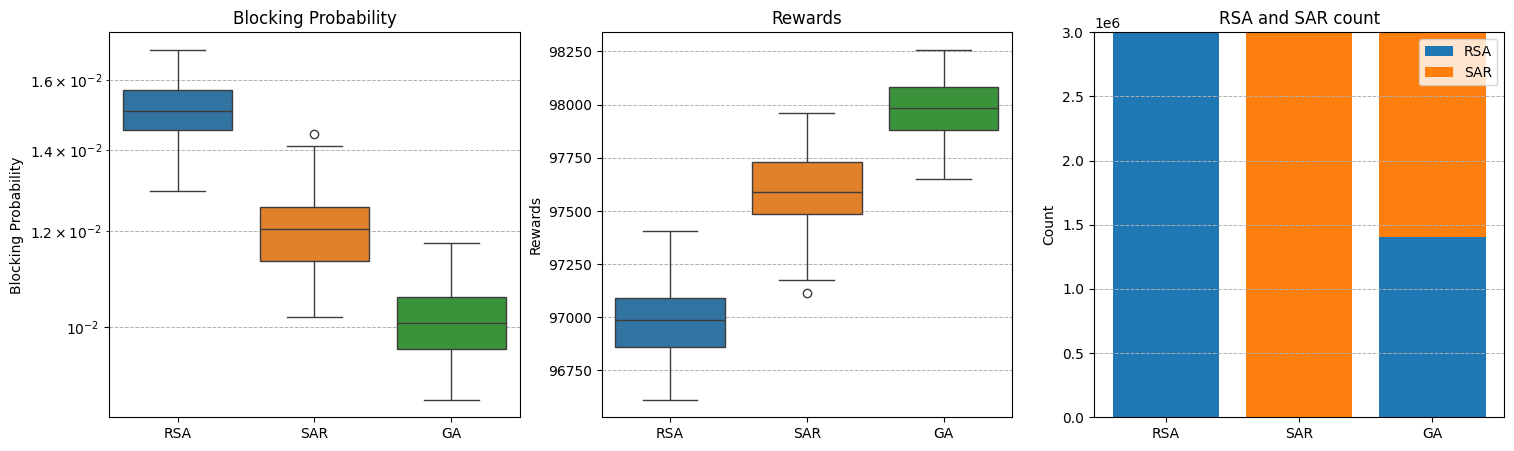

In [12]:
include_models(results_models_300e)

# Testando modelos com diferentes configurações

### Modelo 015

In [13]:
enviroment_type_models = {
    "Observation": "availability-vector",
    "Action": "RSA-SAR",
    "Reward": "RL-defaut",
    "StopCond": "MaxReq",
    "StartCond": "Empty"
}

# Cria o ambiente de simulação
env = Enviroment(
    network_load=300,
    k_routes=K_ROUTES,
    number_of_slots=NUMBER_OF_SLOTS,
    enviroment_type=enviroment_type_models,
    data_folder="PPO_Eval",
)

model_015 = PPO.load("D:\\98_phD_Files\\Projeto 006 - Artigo rede regular iTwo\\logs\\PPO_015\\training\\best_model\\best_model.zip", env=env)

## Retorna a PB para o modelo treinado
results_models_300e['PPO_015_b'] = run_test(env, model_015, num_sim=30, main_seed=123)

Executando a avaliação do modelo
Executando simulação 1 de 30 com seed 15725.
Blocking Probability: 0.01085 | Reward: 97830.0 | Req: 100000
Executando simulação 2 de 30 com seed 28030.
Blocking Probability: 0.01173 | Reward: 97654.0 | Req: 100000
Executando simulação 3 de 30 com seed 17730.
Blocking Probability: 0.01234 | Reward: 97532.0 | Req: 100000
Executando simulação 4 de 30 com seed 61404.
Blocking Probability: 0.01189 | Reward: 97622.0 | Req: 100000
Executando simulação 5 de 30 com seed 63206.
Blocking Probability: 0.01126 | Reward: 97748.0 | Req: 100000
Executando simulação 6 de 30 com seed 15377.
Blocking Probability: 0.01142 | Reward: 97716.0 | Req: 100000
Executando simulação 7 de 30 com seed 73299.
Blocking Probability: 0.01067 | Reward: 97866.0 | Req: 100000
Executando simulação 8 de 30 com seed 46203.
Blocking Probability: 0.01012 | Reward: 97976.0 | Req: 100000
Executando simulação 9 de 30 com seed 89302.
Blocking Probability: 0.0115 | Reward: 97700.0 | Req: 100000
Execu

### Modelo Versão 4

In [14]:
enviroment_type_models = {
    "Observation": "availability-vector",
    "Action": "RSA-SAR",
    "Reward": "RL-defaut",
    "StopCond": "MaxReq",
    "StartCond": "Empty"
}

# Cria o ambiente de simulação
env = Enviroment(
    network_load=300,
    k_routes=K_ROUTES,
    number_of_slots=NUMBER_OF_SLOTS,
    enviroment_type=enviroment_type_models,
    data_folder="PPO_Eval",
)

model_v4 = PPO.load("D:\\98_phD_Files\\Projeto 006 - Artigo rede regular iTwo\\logs\\Train_PPO_40kReqs_300_v4_001\\training\\best_model\\best_model.zip", env=env)

## Retorna a PB para o modelo treinado
results_models_300e['PPO_v4'] = run_test(env, model_v4, num_sim=30, main_seed=123)

Executando a avaliação do modelo
Executando simulação 1 de 30 com seed 15725.
Blocking Probability: 0.01121 | Reward: 97758.0 | Req: 100000
Executando simulação 2 de 30 com seed 28030.
Blocking Probability: 0.01179 | Reward: 97642.0 | Req: 100000
Executando simulação 3 de 30 com seed 17730.
Blocking Probability: 0.01225 | Reward: 97550.0 | Req: 100000
Executando simulação 4 de 30 com seed 61404.
Blocking Probability: 0.01247 | Reward: 97506.0 | Req: 100000
Executando simulação 5 de 30 com seed 63206.
Blocking Probability: 0.01149 | Reward: 97702.0 | Req: 100000
Executando simulação 6 de 30 com seed 15377.
Blocking Probability: 0.01104 | Reward: 97792.0 | Req: 100000
Executando simulação 7 de 30 com seed 73299.
Blocking Probability: 0.01042 | Reward: 97916.0 | Req: 100000
Executando simulação 8 de 30 com seed 46203.
Blocking Probability: 0.01034 | Reward: 97932.0 | Req: 100000
Executando simulação 9 de 30 com seed 89302.
Blocking Probability: 0.01297 | Reward: 97406.0 | Req: 100000
Exec

### Modelo V11

In [15]:
enviroment_type_models = {
    "Observation": "availability-vector",
    "Action": "RSA-SAR",
    "Reward": "RL-defaut",
    "StopCond": "MaxReq",
    "StartCond": "Empty"
}

# Cria o ambiente de simulação
env = Enviroment(
    network_load=300,
    k_routes=K_ROUTES,
    number_of_slots=NUMBER_OF_SLOTS,
    enviroment_type=enviroment_type_models,
    data_folder="PPO_Eval",
)

model_v11 =PPO.load("D:\\98_phD_Files\\Projeto 006 - Artigo rede regular iTwo\\logs\\Train_PPO_40kReqs_300_v11_001\\training\\best_model\\best_model.zip", env=env)

## Retorna a PB para o modelo treinado
results_models_300e['PPO_v11'] = run_test(env, model_v11, num_sim=30, main_seed=123)

Executando a avaliação do modelo
Executando simulação 1 de 30 com seed 15725.
Blocking Probability: 0.01103 | Reward: 97794.0 | Req: 100000
Executando simulação 2 de 30 com seed 28030.
Blocking Probability: 0.01134 | Reward: 97732.0 | Req: 100000
Executando simulação 3 de 30 com seed 17730.
Blocking Probability: 0.01179 | Reward: 97642.0 | Req: 100000
Executando simulação 4 de 30 com seed 61404.
Blocking Probability: 0.01117 | Reward: 97766.0 | Req: 100000
Executando simulação 5 de 30 com seed 63206.
Blocking Probability: 0.01121 | Reward: 97758.0 | Req: 100000
Executando simulação 6 de 30 com seed 15377.
Blocking Probability: 0.01085 | Reward: 97830.0 | Req: 100000
Executando simulação 7 de 30 com seed 73299.
Blocking Probability: 0.01024 | Reward: 97952.0 | Req: 100000
Executando simulação 8 de 30 com seed 46203.
Blocking Probability: 0.00961 | Reward: 98078.0 | Req: 100000
Executando simulação 9 de 30 com seed 89302.
Blocking Probability: 0.01173 | Reward: 97654.0 | Req: 100000
Exec

C:\Users\mathe\AppData\Local\Temp\ipykernel_39572\436873453.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='left')


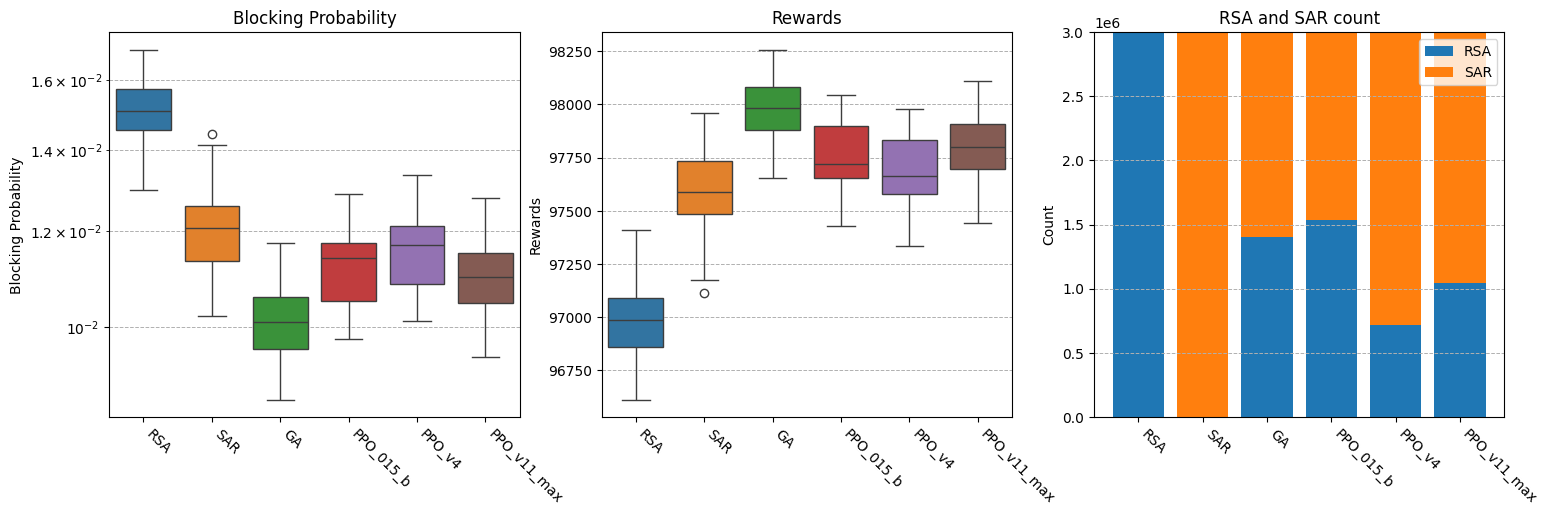

In [32]:
include_models(results_models_300e)

### Modelo V11 v2

In [34]:
enviroment_type_models = {
    "Observation": "availability-vector",
    "Action": "RSA-SAR",
    "Reward": "RL-defaut",
    "StopCond": "MaxReq",
    "StartCond": "Empty"
}

# Cria o ambiente de simulação
env = Enviroment(
    network_load=300,
    k_routes=K_ROUTES,
    number_of_slots=NUMBER_OF_SLOTS,
    enviroment_type=enviroment_type_models,
    data_folder="PPO_Eval",
)

model_v112 = PPO.load("D:\\98_phD_Files\\Projeto 006 - Artigo rede regular iTwo\\logs\\Train_PPO_40kReqs_300_v11v2_003\\training\\best_model\\best_model.zip", env=env)

## Retorna a PB para o modelo treinado
results_models_300e['PPO_v11 v2'] = run_test(env, model_v112, num_sim=30, main_seed=123)

Executando a avaliação do modelo
Executando simulação 1 de 30 com seed 15725.
Blocking Probability: 0.01134 | Reward: 97732.0 | Req: 100000
Executando simulação 2 de 30 com seed 28030.
Blocking Probability: 0.01071 | Reward: 97858.0 | Req: 100000
Executando simulação 3 de 30 com seed 17730.
Blocking Probability: 0.0115 | Reward: 97700.0 | Req: 100000
Executando simulação 4 de 30 com seed 61404.
Blocking Probability: 0.01152 | Reward: 97696.0 | Req: 100000
Executando simulação 5 de 30 com seed 63206.
Blocking Probability: 0.01101 | Reward: 97798.0 | Req: 100000
Executando simulação 6 de 30 com seed 15377.
Blocking Probability: 0.01139 | Reward: 97722.0 | Req: 100000
Executando simulação 7 de 30 com seed 73299.
Blocking Probability: 0.01045 | Reward: 97910.0 | Req: 100000
Executando simulação 8 de 30 com seed 46203.
Blocking Probability: 0.00971 | Reward: 98058.0 | Req: 100000
Executando simulação 9 de 30 com seed 89302.
Blocking Probability: 0.01159 | Reward: 97682.0 | Req: 100000
Execu

### Modelo V11 v3

In [35]:
enviroment_type_models = {
    "Observation": "availability-vector",
    "Action": "RSA-SAR",
    "Reward": "RL-defaut",
    "StopCond": "MaxReq",
    "StartCond": "Empty"
}

# Cria o ambiente de simulação
env = Enviroment(
    network_load=300,
    k_routes=K_ROUTES,
    number_of_slots=NUMBER_OF_SLOTS,
    enviroment_type=enviroment_type_models,
    data_folder="PPO_Eval",
)

model_v113 = PPO.load("D:\\98_phD_Files\\Projeto 006 - Artigo rede regular iTwo\\logs\\Train_PPO_40kReqs_300_v11v3_002\\training\\best_model\\best_model.zip", env=env)

## Retorna a PB para o modelo treinado
results_models_300e['PPO_v11 v3'] = run_test(env, model_v113, num_sim=30, main_seed=123)

Executando a avaliação do modelo
Executando simulação 1 de 30 com seed 15725.
Blocking Probability: 0.01186 | Reward: 97628.0 | Req: 100000
Executando simulação 2 de 30 com seed 28030.
Blocking Probability: 0.01087 | Reward: 97826.0 | Req: 100000
Executando simulação 3 de 30 com seed 17730.
Blocking Probability: 0.01157 | Reward: 97686.0 | Req: 100000
Executando simulação 4 de 30 com seed 61404.
Blocking Probability: 0.01144 | Reward: 97712.0 | Req: 100000
Executando simulação 5 de 30 com seed 63206.
Blocking Probability: 0.01167 | Reward: 97666.0 | Req: 100000
Executando simulação 6 de 30 com seed 15377.
Blocking Probability: 0.01206 | Reward: 97588.0 | Req: 100000
Executando simulação 7 de 30 com seed 73299.
Blocking Probability: 0.01081 | Reward: 97838.0 | Req: 100000
Executando simulação 8 de 30 com seed 46203.
Blocking Probability: 0.01051 | Reward: 97898.0 | Req: 100000
Executando simulação 9 de 30 com seed 89302.
Blocking Probability: 0.01297 | Reward: 97406.0 | Req: 100000
Exec

### Modelo V11 v4

In [36]:
enviroment_type_models = {
    "Observation": "availability-vector",
    "Action": "RSA-SAR",
    "Reward": "RL-defaut",
    "StopCond": "MaxReq",
    "StartCond": "Empty"
}

# Cria o ambiente de simulação
env = Enviroment(
    network_load=300,
    k_routes=K_ROUTES,
    number_of_slots=NUMBER_OF_SLOTS,
    enviroment_type=enviroment_type_models,
    data_folder="PPO_Eval",
)

model_v114 = PPO.load("D:\\98_phD_Files\\Projeto 006 - Artigo rede regular iTwo\\logs\\Train_PPO_40kReqs_300_v11v4_003\\training\\best_model\\best_model.zip", env=env)

## Retorna a PB para o modelo treinado
results_models_300e['PPO_v11 v4'] = run_test(env, model_v114, num_sim=30, main_seed=123)

Executando a avaliação do modelo
Executando simulação 1 de 30 com seed 15725.
Blocking Probability: 0.0119 | Reward: 97620.0 | Req: 100000
Executando simulação 2 de 30 com seed 28030.
Blocking Probability: 0.01109 | Reward: 97782.0 | Req: 100000
Executando simulação 3 de 30 com seed 17730.
Blocking Probability: 0.01216 | Reward: 97568.0 | Req: 100000
Executando simulação 4 de 30 com seed 61404.
Blocking Probability: 0.01247 | Reward: 97506.0 | Req: 100000
Executando simulação 5 de 30 com seed 63206.
Blocking Probability: 0.01152 | Reward: 97696.0 | Req: 100000
Executando simulação 6 de 30 com seed 15377.
Blocking Probability: 0.01177 | Reward: 97646.0 | Req: 100000
Executando simulação 7 de 30 com seed 73299.
Blocking Probability: 0.01043 | Reward: 97914.0 | Req: 100000
Executando simulação 8 de 30 com seed 46203.
Blocking Probability: 0.01064 | Reward: 97872.0 | Req: 100000
Executando simulação 9 de 30 com seed 89302.
Blocking Probability: 0.01234 | Reward: 97532.0 | Req: 100000
Execu

### MOdelo V11 v5

In [42]:
enviroment_type_models = {
    "Observation": "availability-vector",
    "Action": "RSA-SAR",
    "Reward": "RL-defaut",
    "StopCond": "MaxReq",
    "StartCond": "Empty"
}

# Cria o ambiente de simulação
env = Enviroment(
    network_load=300,
    k_routes=K_ROUTES,
    number_of_slots=NUMBER_OF_SLOTS,
    enviroment_type=enviroment_type_models,
    data_folder="PPO_Eval",
)

model_v115 = PPO.load("D:\\98_phD_Files\\Projeto 006 - Artigo rede regular iTwo\\logs\\Train_PPO_40kReqs_300_v11v2_004\\training\\best_model\\best_model.zip", env=env)

## Retorna a PB para o modelo treinado
results_models_300e['PPO_v11 v5'] = run_test(env, model_v115, num_sim=30, main_seed=123)

Executando a avaliação do modelo
Executando simulação 1 de 30 com seed 15725.
Blocking Probability: 0.01174 | Reward: 97652.0 | Req: 100000
Executando simulação 2 de 30 com seed 28030.
Blocking Probability: 0.01201 | Reward: 97598.0 | Req: 100000
Executando simulação 3 de 30 com seed 17730.
Blocking Probability: 0.0135 | Reward: 97300.0 | Req: 100000
Executando simulação 4 de 30 com seed 61404.
Blocking Probability: 0.01207 | Reward: 97586.0 | Req: 100000
Executando simulação 5 de 30 com seed 63206.
Blocking Probability: 0.01188 | Reward: 97624.0 | Req: 100000
Executando simulação 6 de 30 com seed 15377.
Blocking Probability: 0.01234 | Reward: 97532.0 | Req: 100000
Executando simulação 7 de 30 com seed 73299.
Blocking Probability: 0.01087 | Reward: 97826.0 | Req: 100000
Executando simulação 8 de 30 com seed 46203.
Blocking Probability: 0.01146 | Reward: 97708.0 | Req: 100000
Executando simulação 9 de 30 com seed 89302.
Blocking Probability: 0.0134 | Reward: 97320.0 | Req: 100000
Execut

### Modelo TRPO

In [39]:
from sb3_contrib import TRPO

enviroment_type_models = {
    "Observation": "availability-vector",
    "Action": "RSA-SAR",
    "Reward": "RL-defaut",
    "StopCond": "MaxReq",
    "StartCond": "Empty"
}

# Cria o ambiente de simulação
env = Enviroment(
    network_load=300,
    k_routes=K_ROUTES,
    number_of_slots=NUMBER_OF_SLOTS,
    enviroment_type=enviroment_type_models,
    data_folder="PPO_Eval",
)

model_TRPO = TRPO.load("D:\\98_phD_Files\\Projeto 006 - Artigo rede regular iTwo\\logs\\Train_TRPO_40kReqs_300_v1_001\\training\\best_model\\best_model.zip", env=env)

## Retorna a PB para o modelo treinado
results_models_300e['TRPO'] = run_test(env, model_TRPO, num_sim=30, main_seed=123)

Executando a avaliação do modelo
Executando simulação 1 de 30 com seed 15725.
Blocking Probability: 0.01206 | Reward: 97588.0 | Req: 100000
Executando simulação 2 de 30 com seed 28030.
Blocking Probability: 0.01268 | Reward: 97464.0 | Req: 100000
Executando simulação 3 de 30 com seed 17730.
Blocking Probability: 0.01349 | Reward: 97302.0 | Req: 100000
Executando simulação 4 de 30 com seed 61404.
Blocking Probability: 0.01176 | Reward: 97648.0 | Req: 100000
Executando simulação 5 de 30 com seed 63206.
Blocking Probability: 0.01203 | Reward: 97594.0 | Req: 100000
Executando simulação 6 de 30 com seed 15377.
Blocking Probability: 0.01251 | Reward: 97498.0 | Req: 100000
Executando simulação 7 de 30 com seed 73299.
Blocking Probability: 0.01147 | Reward: 97706.0 | Req: 100000
Executando simulação 8 de 30 com seed 46203.
Blocking Probability: 0.01141 | Reward: 97718.0 | Req: 100000
Executando simulação 9 de 30 com seed 89302.
Blocking Probability: 0.01341 | Reward: 97318.0 | Req: 100000
Exec

### Gráficos

C:\Users\mathe\AppData\Local\Temp\ipykernel_13424\436873453.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='left')


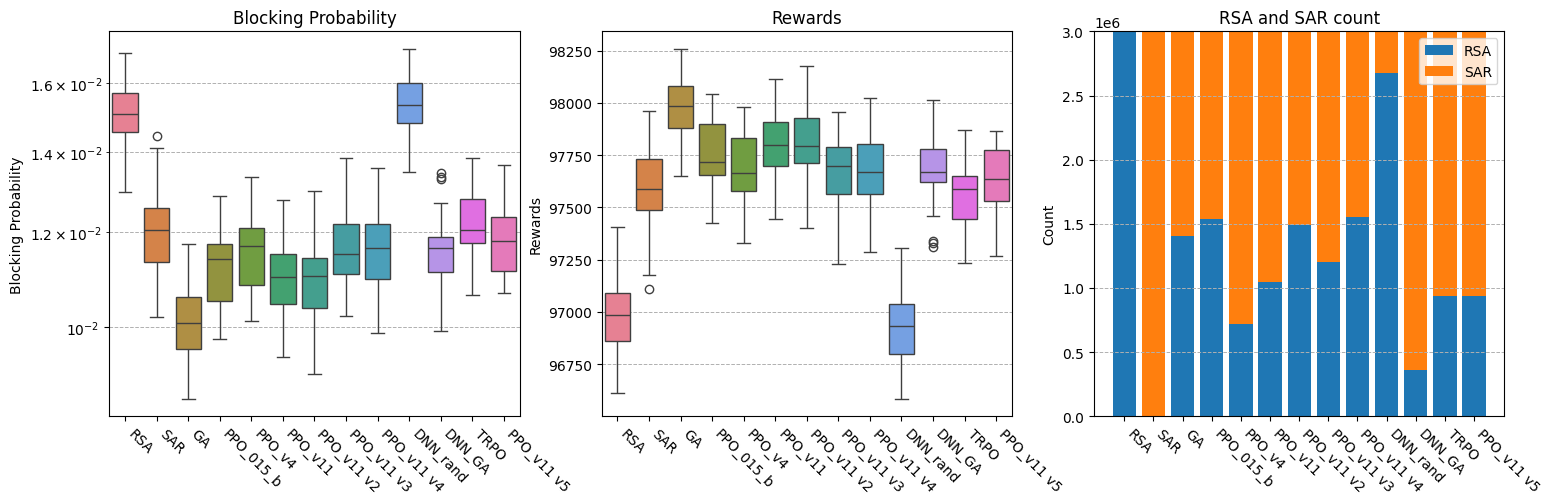

In [43]:
include_models(results_models_300e)

In [44]:
# Salva os resultados
with open("results_models_300e.pkl", "wb") as f:
    pickle.dump(results_models_300e, f)

## Modelos de DNN com GA

In [21]:
def run_test_DNN(env, model, num_sim=10, main_seed=42):
    """ Realiza a simulação do modelo em um ambiente de simulação e retorna as probabilidades de bloqueio e as recompensas médias.

    Args:
        env (Enviroment): Ambiente de simulação.
        model (Model): Modelo a ser testado.
        num_sim (int): Número de simulações a serem realizadas.

    Returns:
        pbs (np.array): Probabilidades de bloqueio.
        reward (np.array): Recompensas médias.
    """

    number_of_nodes = env._number_of_nodes

    # # Verifica se model é uma string com o nome do modelo
    # if isinstance(model, str):
    #     if model not in ['RSA', 'SAR']:
    #         raise ValueError("Model must be 'RSA', 'SAR', a trained model from Stable Baselines 3 or a numpy array with the size equal to the number of nodes squared.")
    # else:
    #     if not hasattr(model, 'predict') and not isinstance(model, np.ndarray) and model.shape != (number_of_nodes**2,):
    #         raise ValueError("Model must be 'RSA', 'SAR', a trained model from Stable Baselines 3 or a numpy array with the size equal to the number of nodes squared.")
    
    # if isinstance(model, str):
    #     if model == 'RSA':
    #         print("Executando a avaliação do RSA")
    #     elif model == 'SAR':
    #         print("Executando a avaliação do SAR")
    # elif isinstance(model, np.ndarray):
    #     print("Executando a avaliação do GA")
    # else:
    #     print("Executando a avaliação do modelo")

    # Reseta a seed para garantir a reprodutibilidade dos resultados
    np.random.seed(main_seed)

    # Gera uma seed para cada simulação
    seeds = np.random.randint(0, 100_000, num_sim, dtype=int)

    # Cria um array para armazenar as probabilidades de bloqueio e as recompensas de cada simulação
    pbs = np.zeros(num_sim)
    rewards = np.zeros(num_sim)

    RSA_SAR_count = [0, 0]

    # Executa as simulações
    for i, seed in enumerate(seeds):

        print(f"Executando simulação {i+1} de {num_sim} com seed {seed}.")

        # Reseta o ambiente para garantir que ele esteja no estado inicial usando a seed
        state, info = env.reset(int(seed))

        # Executa a simulação
        while True:

            if isinstance(model, str):
                if model == 'RSA':
                    alg_heuristic = 0
                elif model == 'SAR':
                    alg_heuristic = 1
            elif isinstance(model, np.ndarray):
                alg_heuristic = model[state[1] + state[0] * 14]
            else:
                #alg_heuristic = model.predict(observation=state, deterministic=True)[0]
                alg_heuristic = model(th.tensor(state, dtype=th.float32)).argmax().item()

            RSA_SAR_count[alg_heuristic] += 1

            state, _, done, trunk, info = env.step(alg_heuristic)

            if (done or trunk) and rewards[i] == 0:
                rewards[i] = env._reward_episode
                break

        pbs[i] = info['total_number_of_blocks'] / info['last_request']

        print(f"Blocking Probability: {pbs[i]} | Reward: {rewards[i]} | Req: {info['last_request']}")

    print(f"\nBlocking Probability: {np.mean(pbs)} | Min: {np.min(pbs)} | Max: {np.max(pbs)} | +- {np.std(pbs)}")
    print(f"Reward: {np.mean(rewards)} | Min: {np.min(rewards)} | Max: {np.max(rewards)} | +- {np.std(rewards)}")
    print(f"RSA count: {RSA_SAR_count[0]} ({RSA_SAR_count[0]/(RSA_SAR_count[0]+RSA_SAR_count[1]):.2%}) | SAR count: {RSA_SAR_count[1]} ({RSA_SAR_count[1]/(RSA_SAR_count[0]+RSA_SAR_count[1]):.2%})")

    return {
        'pbs': pbs,
        'rewards': rewards,
        'RSA_SAR_count': RSA_SAR_count
    }

In [23]:
import torch.nn as nn

enviroment_type_test = {
    "Observation": "ODD-one-hot",
    "Action": "RSA-SAR",
    "Reward": "RL-defaut",
    "StopCond": "MaxReq",
    "StartCond": "Empty"
}

# Cria o ambiente de simulação
env = Enviroment(network_load = 300, k_routes = 3, number_of_slots = 128, enviroment_type=enviroment_type_test, data_folder="DNN")

input_size = env.observation_space.n
output_size = env.action_space.n

class DNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DNN, self).__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.LeakyReLU(inplace=True),
            nn.Linear(256, 128),
            nn.LeakyReLU(inplace=True),
            nn.Linear(128, output_size),
            nn.Softmax(dim=1) if output_size > 2 else nn.Sigmoid()
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

In [24]:
model_rand = DNN(input_size, output_size)

In [25]:
results_models_300e['DNN_rand'] = run_test_DNN(env, model_rand, num_sim=30, main_seed=123)

Executando simulação 1 de 30 com seed 15725.
Blocking Probability: 0.01582 | Reward: 96836.0 | Req: 100000
Executando simulação 2 de 30 com seed 28030.
Blocking Probability: 0.01483 | Reward: 97034.0 | Req: 100000
Executando simulação 3 de 30 com seed 17730.
Blocking Probability: 0.01628 | Reward: 96744.0 | Req: 100000
Executando simulação 4 de 30 com seed 61404.
Blocking Probability: 0.01545 | Reward: 96910.0 | Req: 100000
Executando simulação 5 de 30 com seed 63206.
Blocking Probability: 0.0153 | Reward: 96940.0 | Req: 100000
Executando simulação 6 de 30 com seed 15377.
Blocking Probability: 0.01606 | Reward: 96788.0 | Req: 100000
Executando simulação 7 de 30 com seed 73299.
Blocking Probability: 0.0141 | Reward: 97180.0 | Req: 100000
Executando simulação 8 de 30 com seed 46203.
Blocking Probability: 0.01347 | Reward: 97306.0 | Req: 100000
Executando simulação 9 de 30 com seed 89302.
Blocking Probability: 0.01696 | Reward: 96608.0 | Req: 100000
Executando simulação 10 de 30 com seed 

In [26]:
model_GA = DNN(input_size, output_size)

In [27]:
with open("best_solution.pickle", "rb") as f:
    ga_solution = pickle.load(f)

In [29]:
chromossome_solution = ga_solution[0]

In [30]:
# Carregando os pesos no modelo
weight_index = 0
for param in model_GA.parameters():
    param.data.copy_(th.tensor(chromossome_solution[weight_index:weight_index + param.numel()]).reshape(param.shape))
    weight_index += param.numel()

In [31]:
model_GA.eval()

with th.no_grad():
    # Executando a simulação
    results_models_300e['DNN_GA'] = run_test_DNN(env, model_GA, num_sim=30, main_seed=123)


Executando simulação 1 de 30 com seed 15725.
Blocking Probability: 0.01179 | Reward: 97642.0 | Req: 100000
Executando simulação 2 de 30 com seed 28030.
Blocking Probability: 0.01147 | Reward: 97706.0 | Req: 100000
Executando simulação 3 de 30 com seed 17730.
Blocking Probability: 0.01244 | Reward: 97512.0 | Req: 100000
Executando simulação 4 de 30 com seed 61404.
Blocking Probability: 0.01176 | Reward: 97648.0 | Req: 100000
Executando simulação 5 de 30 com seed 63206.
Blocking Probability: 0.01185 | Reward: 97630.0 | Req: 100000
Executando simulação 6 de 30 com seed 15377.
Blocking Probability: 0.01158 | Reward: 97684.0 | Req: 100000
Executando simulação 7 de 30 com seed 73299.
Blocking Probability: 0.01136 | Reward: 97728.0 | Req: 100000
Executando simulação 8 de 30 com seed 46203.
Blocking Probability: 0.01079 | Reward: 97842.0 | Req: 100000
Executando simulação 9 de 30 com seed 89302.
Blocking Probability: 0.01336 | Reward: 97328.0 | Req: 100000
Executando simulação 10 de 30 com see

## Gráfico

C:\Users\mathe\AppData\Local\Temp\ipykernel_13424\436873453.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='left')


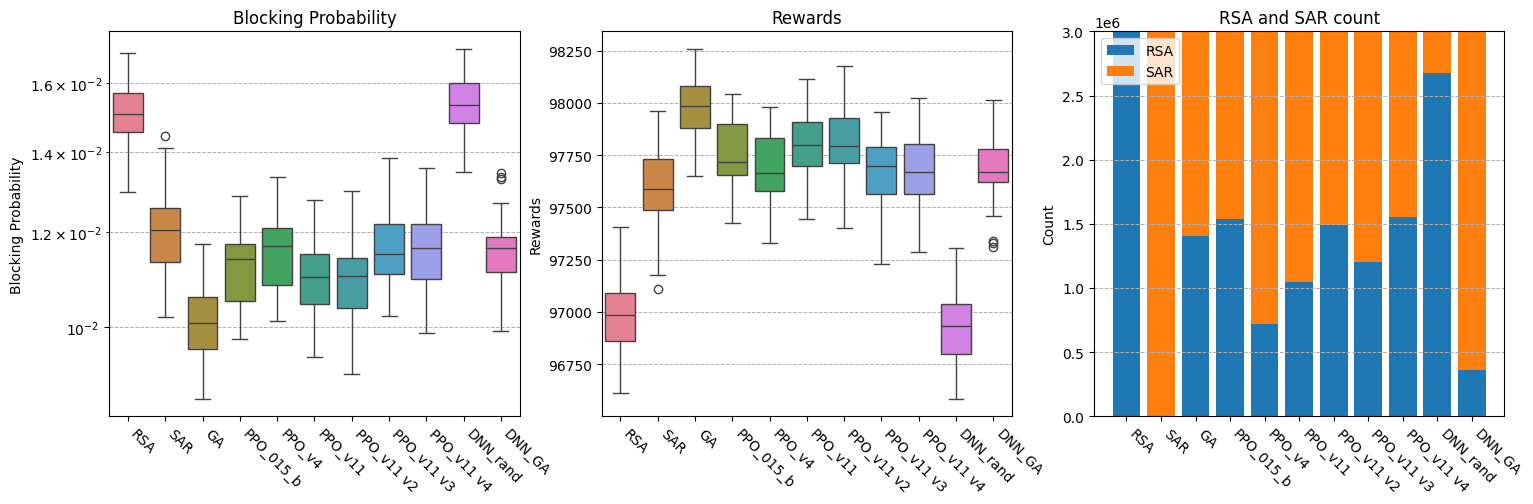

In [33]:
include_models(results_models_300e)

In [45]:
import pickle

with open("results_models_300e.pkl", "rb") as f:
    results_models_300e = pickle.load(f)

In [50]:
results = {
    "R-SA": results_models_300e["RSA"],
    "SA-R": results_models_300e["SAR"],
    "H-R-SA": results_models_300e["GA"],    
    "PPO v4": results_models_300e["PPO_v4"],
    "PPO v11": results_models_300e["PPO_v11"],
}

C:\Users\mathe\AppData\Local\Temp\ipykernel_46716\436873453.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='left')


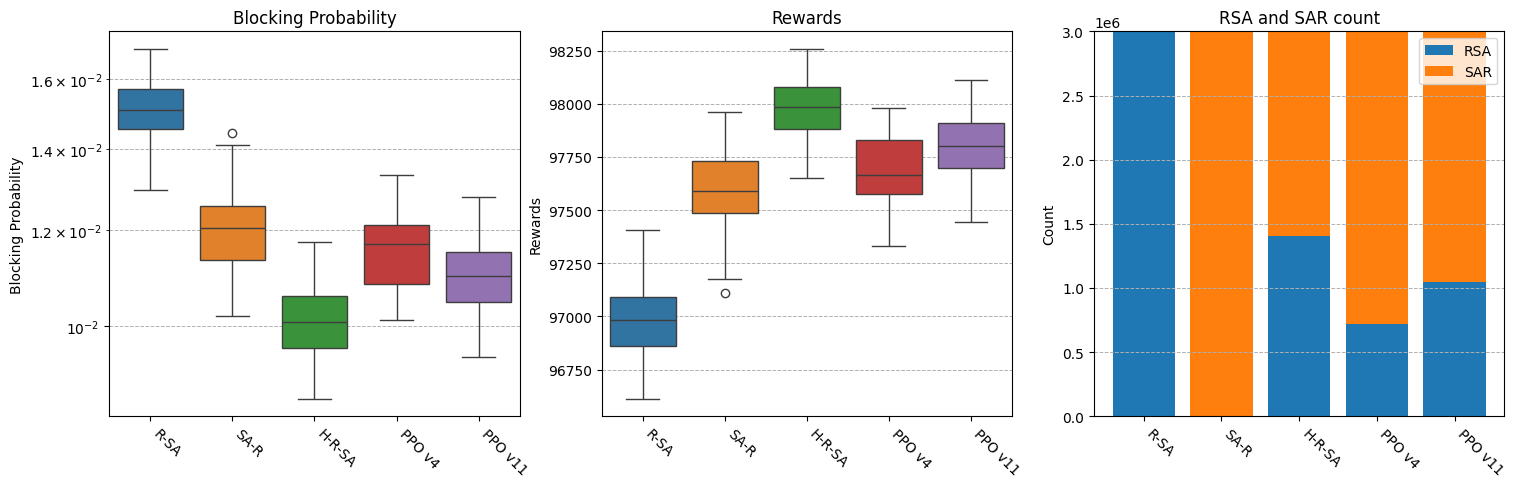

In [51]:
include_models(results)

# Curva de PB

In [6]:
NETWORK_LOADS = np.linspace(240, 300, 7, dtype=int)

In [7]:
enviroment_type_test = {
    "Observation": "OD",
    "Action": "RSA-SAR",
    "Reward": "RL-defaut",
    "StopCond": "MaxReq",
    "StartCond": "Empty"
}

## R-SA

In [8]:
RSA_DATA_LOADS = []

for network_load in NETWORK_LOADS:
    print(f"Network Load: {network_load}")

    # Cria o ambiente de simulação
    env = Enviroment(
        network_load=network_load,
        k_routes=K_ROUTES,
        number_of_slots=NUMBER_OF_SLOTS,
        enviroment_type=enviroment_type_test,
        data_folder="CURVE_LOAD",
    )

    data = run_test(env, 'RSA', num_sim=15, main_seed=123)

    RSA_DATA_LOADS.append(data)

Network Load: 240
Executando a avaliação do RSA
Executando simulação 1 de 15 com seed 15725.
Blocking Probability: 0.00099 | Reward: 998020.0 | Req: 1000000
Executando simulação 2 de 15 com seed 28030.
Blocking Probability: 0.000994 | Reward: 998012.0 | Req: 1000000
Executando simulação 3 de 15 com seed 17730.
Blocking Probability: 0.000955 | Reward: 998090.0 | Req: 1000000
Executando simulação 4 de 15 com seed 61404.
Blocking Probability: 0.000935 | Reward: 998130.0 | Req: 1000000
Executando simulação 5 de 15 com seed 63206.
Blocking Probability: 0.001038 | Reward: 997924.0 | Req: 1000000
Executando simulação 6 de 15 com seed 15377.
Blocking Probability: 0.000965 | Reward: 998070.0 | Req: 1000000
Executando simulação 7 de 15 com seed 73299.
Blocking Probability: 0.001033 | Reward: 997934.0 | Req: 1000000
Executando simulação 8 de 15 com seed 46203.
Blocking Probability: 0.000951 | Reward: 998098.0 | Req: 1000000
Executando simulação 9 de 15 com seed 89302.
Blocking Probability: 0.0009

## SAR

In [14]:
SAR_DATA_LOADS = []

for network_load in NETWORK_LOADS:
    print(f"Network Load: {network_load}")

    # Cria o ambiente de simulação
    env = Enviroment(
        network_load=network_load,
        k_routes=K_ROUTES,
        number_of_slots=NUMBER_OF_SLOTS,
        enviroment_type=enviroment_type_test,
        data_folder="CURVE_LOAD",
    )

    data = run_test(env, 'SAR', num_sim=15, main_seed=123)

    SAR_DATA_LOADS.append(data)

Network Load: 240
Executando a avaliação do SAR
Executando simulação 1 de 15 com seed 15725.
Blocking Probability: 0.000189 | Reward: 999622.0 | Req: 1000000
Executando simulação 2 de 15 com seed 28030.
Blocking Probability: 0.000149 | Reward: 999702.0 | Req: 1000000
Executando simulação 3 de 15 com seed 17730.
Blocking Probability: 0.000169 | Reward: 999662.0 | Req: 1000000
Executando simulação 4 de 15 com seed 61404.
Blocking Probability: 0.000207 | Reward: 999586.0 | Req: 1000000
Executando simulação 5 de 15 com seed 63206.
Blocking Probability: 0.000152 | Reward: 999696.0 | Req: 1000000
Executando simulação 6 de 15 com seed 15377.
Blocking Probability: 0.000157 | Reward: 999686.0 | Req: 1000000
Executando simulação 7 de 15 com seed 73299.
Blocking Probability: 0.00022 | Reward: 999560.0 | Req: 1000000
Executando simulação 8 de 15 com seed 46203.
Blocking Probability: 0.000158 | Reward: 999684.0 | Req: 1000000
Executando simulação 9 de 15 com seed 89302.
Blocking Probability: 0.0001

## GA MAth

In [41]:
GA_MATH_DATA_LOADS = []

chromossome_solution = np.array([0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1,])

for network_load in NETWORK_LOADS:
    print(f"Network Load: {network_load}")

    # Cria o ambiente de simulação
    env = Enviroment(
        network_load=network_load,
        k_routes=K_ROUTES,
        number_of_slots=NUMBER_OF_SLOTS,
        enviroment_type=enviroment_type_test,
        data_folder="CURVE_LOAD",
    )

    data = run_test(env, chromossome_solution, num_sim=30, main_seed=123)

    GA_MATH_DATA_LOADS.append(data)

Network Load: 240
Executando a avaliação do GA
Executando simulação 1 de 30 com seed 15725.
Blocking Probability: 0.000158 | Reward: 999684.0 | Req: 1000000
Executando simulação 2 de 30 com seed 28030.
Blocking Probability: 0.000165 | Reward: 999670.0 | Req: 1000000
Executando simulação 3 de 30 com seed 17730.
Blocking Probability: 0.000179 | Reward: 999642.0 | Req: 1000000
Executando simulação 4 de 30 com seed 61404.
Blocking Probability: 0.000175 | Reward: 999650.0 | Req: 1000000
Executando simulação 5 de 30 com seed 63206.
Blocking Probability: 0.000169 | Reward: 999662.0 | Req: 1000000
Executando simulação 6 de 30 com seed 15377.
Blocking Probability: 0.000189 | Reward: 999622.0 | Req: 1000000
Executando simulação 7 de 30 com seed 73299.
Blocking Probability: 0.000187 | Reward: 999626.0 | Req: 1000000
Executando simulação 8 de 30 com seed 46203.
Blocking Probability: 0.000167 | Reward: 999666.0 | Req: 1000000
Executando simulação 9 de 30 com seed 89302.
Blocking Probability: 0.0001

## GA Hermano

In [38]:
GA_HERMANO_DATA_LOADS = []

chromossome_solution = np.array([1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1])

for network_load in NETWORK_LOADS:
    print(f"Network Load: {network_load}")

    # Cria o ambiente de simulação
    env = Enviroment(
        network_load=network_load,
        k_routes=K_ROUTES,
        number_of_slots=NUMBER_OF_SLOTS,
        enviroment_type=enviroment_type_test,
        data_folder="CURVE_LOAD",
    )

    data = run_test(env, chromossome_solution, num_sim=3, main_seed=123)

    GA_HERMANO_DATA_LOADS.append(data)

Network Load: 240
Executando a avaliação do GA
Executando simulação 1 de 3 com seed 15725.
Blocking Probability: 0.000205 | Reward: 999590.0 | Req: 1000000
Executando simulação 2 de 3 com seed 28030.
Blocking Probability: 0.00016 | Reward: 999680.0 | Req: 1000000
Executando simulação 3 de 3 com seed 17730.
Blocking Probability: 0.000187 | Reward: 999626.0 | Req: 1000000

Blocking Probability: 0.000184 | Min: 0.00016 | Max: 0.000205 | +- 1.849324200890692e-05
Reward: 999632.0 | Min: 999590.0 | Max: 999680.0 | +- 36.98648401781386
RSA count: 1468013 (48.93%) | SAR count: 1531987 (51.07%)
Network Load: 250
Executando a avaliação do GA
Executando simulação 1 de 3 com seed 15725.
Blocking Probability: 0.00045 | Reward: 999100.0 | Req: 1000000
Executando simulação 2 de 3 com seed 28030.
Blocking Probability: 0.000467 | Reward: 999066.0 | Req: 1000000
Executando simulação 3 de 3 com seed 17730.
Blocking Probability: 0.000399 | Reward: 999202.0 | Req: 1000000

Blocking Probability: 0.000438666

## Modelo V11

In [42]:
enviroment_type_models = {
    "Observation": "availability-vector",
    "Action": "RSA-SAR",
    "Reward": "RL-defaut",
    "StopCond": "MaxReq",
    "StartCond": "Empty"
}

MODEL11_DATA_LOADS = []

for network_load in NETWORK_LOADS:
    print(f"Network Load: {network_load}")

    # Cria o ambiente de simulação
    env = Enviroment(
        network_load=network_load,
        k_routes=K_ROUTES,
        number_of_slots=NUMBER_OF_SLOTS,
        enviroment_type=enviroment_type_models,
        data_folder="CURVE_LOAD",
    )

    model_v11 =PPO.load("D:\\98_phD_Files\\Projeto 006 - Artigo rede regular iTwo\\logs\\Train_PPO_40kReqs_300_v11_001\\training\\best_model\\best_model.zip", env=env)

    data = run_test(env, model_v11, num_sim=30, main_seed=123)

    MODEL11_DATA_LOADS.append(data)


Network Load: 240
Executando a avaliação do modelo
Executando simulação 1 de 30 com seed 15725.
Blocking Probability: 0.000153 | Reward: 999694.0 | Req: 1000000
Executando simulação 2 de 30 com seed 28030.
Blocking Probability: 0.000126 | Reward: 999748.0 | Req: 1000000
Executando simulação 3 de 30 com seed 17730.
Blocking Probability: 0.000151 | Reward: 999698.0 | Req: 1000000
Executando simulação 4 de 30 com seed 61404.
Blocking Probability: 0.000156 | Reward: 999688.0 | Req: 1000000
Executando simulação 5 de 30 com seed 63206.
Blocking Probability: 0.000145 | Reward: 999710.0 | Req: 1000000
Executando simulação 6 de 30 com seed 15377.
Blocking Probability: 0.000135 | Reward: 999730.0 | Req: 1000000
Executando simulação 7 de 30 com seed 73299.
Blocking Probability: 0.000171 | Reward: 999658.0 | Req: 1000000
Executando simulação 8 de 30 com seed 46203.
Blocking Probability: 0.000114 | Reward: 999772.0 | Req: 1000000
Executando simulação 9 de 30 com seed 89302.
Blocking Probability: 0.

KeyboardInterrupt: 

## Gráfico

In [54]:
MODEL11_DATA_LOADS

[{'pbs': array([0.000153, 0.000126, 0.000151, 0.000156, 0.000145, 0.000135,
         0.000171, 0.000114, 0.000129, 0.000161, 0.000146, 0.000176,
         0.000153, 0.000157, 0.000138, 0.000135, 0.000154, 0.000111,
         0.000133, 0.000156, 0.000151, 0.000158, 0.000142, 0.000166,
         0.000116, 0.000129, 0.000151, 0.00011 , 0.000129, 0.000176]),
  'rewards': array([999694., 999748., 999698., 999688., 999710., 999730., 999658.,
         999772., 999742., 999678., 999708., 999648., 999694., 999686.,
         999724., 999730., 999692., 999778., 999734., 999688., 999698.,
         999684., 999716., 999668., 999768., 999742., 999698., 999780.,
         999742., 999648.]),
  'RSA_SAR_count': [6409109, 23590891]},
 {'pbs': array([0.000403, 0.000386, 0.00047 , 0.000424, 0.000417, 0.000416,
         0.000436, 0.000431, 0.00045 , 0.000466, 0.000382, 0.00044 ,
         0.000405, 0.000483, 0.000454, 0.000416, 0.000449, 0.000388,
         0.000408, 0.000438, 0.000462, 0.000414, 0.000363, 0.00

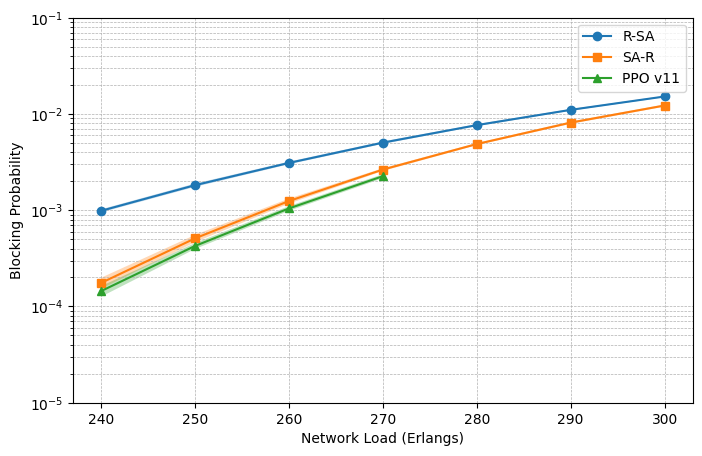

In [56]:
# Cria um gráfico com a probabilidade de bloqueio para cada carga de rede simulada. O valor das probabilidades de bloqueio é a média de 15 simulações. Devem ser apresentados a marge de erro de 1 desvio padrão.

fig, ax = plt.subplots(figsize=(8, 5))

ax.semilogy(NETWORK_LOADS, [np.mean(data['pbs']) for data in RSA_DATA_LOADS], label="R-SA", marker="o")
ax.fill_between(NETWORK_LOADS, [np.mean(data['pbs']) - np.std(data['pbs']) for data in RSA_DATA_LOADS], [np.mean(data['pbs']) + np.std(data['pbs']) for data in RSA_DATA_LOADS], alpha=0.3)

ax.semilogy(NETWORK_LOADS, [np.mean(data['pbs']) for data in SAR_DATA_LOADS], label="SA-R", marker="s")
ax.fill_between(NETWORK_LOADS, [np.mean(data['pbs']) - np.std(data['pbs']) for data in SAR_DATA_LOADS], [np.mean(data['pbs']) + np.std(data['pbs']) for data in SAR_DATA_LOADS], alpha=0.3)

# ax.semilogy(NETWORK_LOADS, [np.mean(data['pbs']) for data in GA_MATH_DATA_LOADS], label="GA", marker="x")
# ax.fill_between(NETWORK_LOADS, [np.mean(data['pbs']) - np.std(data['pbs']) for data in GA_MATH_DATA_LOADS], [np.mean(data['pbs']) + np.std(data['pbs']) for data in GA_MATH_DATA_LOADS], alpha=0.3)

# ax.semilogy(NETWORK_LOADS, [np.mean(data['pbs']) for data in GA_HERMANO_DATA_LOADS], label="GA Hermano", marker="d")
# ax.fill_between(NETWORK_LOADS, [np.mean(data['pbs']) - np.std(data['pbs']) for data in GA_HERMANO_DATA_LOADS], [np.mean(data['pbs']) + np.std(data['pbs']) for data in GA_HERMANO_DATA_LOADS], alpha=0.3)

ax.semilogy([240, 250, 260, 270], [np.mean(data['pbs']) for data in MODEL11_DATA_LOADS], label="PPO v11", marker="^")
ax.fill_between([240, 250, 260, 270], [np.mean(data['pbs']) - np.std(data['pbs']) for data in MODEL11_DATA_LOADS], [np.mean(data['pbs']) + np.std(data['pbs']) for data in MODEL11_DATA_LOADS], alpha=0.3)


# Define o limite do eixo y
ax.set_ylim(1e-5, 1e-1)

#ax.set_title("Blocking Probability x Network Load")
ax.set_xlabel("Network Load (Erlangs)")
ax.set_ylabel("Blocking Probability")
ax.grid(axis="both", which="both", linestyle="--", linewidth=0.5)
ax.legend()

plt.show()

In [33]:
import pickle

# Salva os resultados
with open("RSA_curve_load.pkl", "wb") as f:
    pickle.dump(RSA_DATA_LOADS, f)

with open("SAR_curve_load.pkl", "wb") as f:
    pickle.dump(SAR_DATA_LOADS, f)

# Boxplot em carga de 260 Erlangs

In [57]:
boxplot_data_240e = {
}


In [58]:

# Cria o ambiente de simulação
env = Enviroment(
    network_load=240,
    k_routes=K_ROUTES,
    number_of_slots=NUMBER_OF_SLOTS,
    enviroment_type=enviroment_type_test,
    data_folder="Evaluation_RSA_240e",
)

boxplot_data_240e['RSA'] = run_test(env, 'RSA', num_sim=30, main_seed=123)

Executando a avaliação do RSA
Executando simulação 1 de 30 com seed 15725.
Blocking Probability: 0.00099 | Reward: 998020.0 | Req: 1000000
Executando simulação 2 de 30 com seed 28030.
Blocking Probability: 0.000994 | Reward: 998012.0 | Req: 1000000
Executando simulação 3 de 30 com seed 17730.
Blocking Probability: 0.000955 | Reward: 998090.0 | Req: 1000000
Executando simulação 4 de 30 com seed 61404.
Blocking Probability: 0.000935 | Reward: 998130.0 | Req: 1000000
Executando simulação 5 de 30 com seed 63206.
Blocking Probability: 0.001038 | Reward: 997924.0 | Req: 1000000
Executando simulação 6 de 30 com seed 15377.
Blocking Probability: 0.000965 | Reward: 998070.0 | Req: 1000000
Executando simulação 7 de 30 com seed 73299.
Blocking Probability: 0.001033 | Reward: 997934.0 | Req: 1000000
Executando simulação 8 de 30 com seed 46203.
Blocking Probability: 0.000951 | Reward: 998098.0 | Req: 1000000
Executando simulação 9 de 30 com seed 89302.
Blocking Probability: 0.00097 | Reward: 998060

In [59]:
# Cria o ambiente de simulação
env = Enviroment(
    network_load=240,
    k_routes=K_ROUTES,
    number_of_slots=NUMBER_OF_SLOTS,
    enviroment_type=enviroment_type_test,
    data_folder="Evaluation_RSA_240e",
)

boxplot_data_240e['SAR'] = run_test(env, 'SAR', num_sim=30, main_seed=123)

Executando a avaliação do SAR
Executando simulação 1 de 30 com seed 15725.
Blocking Probability: 0.000189 | Reward: 999622.0 | Req: 1000000
Executando simulação 2 de 30 com seed 28030.
Blocking Probability: 0.000149 | Reward: 999702.0 | Req: 1000000
Executando simulação 3 de 30 com seed 17730.
Blocking Probability: 0.000169 | Reward: 999662.0 | Req: 1000000
Executando simulação 4 de 30 com seed 61404.
Blocking Probability: 0.000207 | Reward: 999586.0 | Req: 1000000
Executando simulação 5 de 30 com seed 63206.
Blocking Probability: 0.000152 | Reward: 999696.0 | Req: 1000000
Executando simulação 6 de 30 com seed 15377.
Blocking Probability: 0.000157 | Reward: 999686.0 | Req: 1000000
Executando simulação 7 de 30 com seed 73299.
Blocking Probability: 0.00022 | Reward: 999560.0 | Req: 1000000
Executando simulação 8 de 30 com seed 46203.
Blocking Probability: 0.000158 | Reward: 999684.0 | Req: 1000000
Executando simulação 9 de 30 com seed 89302.
Blocking Probability: 0.00014 | Reward: 999720

In [61]:
chromossome_solution = np.array([0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1,])

# Cria o ambiente de simulação
env = Enviroment(
    network_load=240,
    k_routes=K_ROUTES,
    number_of_slots=NUMBER_OF_SLOTS,
    enviroment_type=enviroment_type_test,
    data_folder="Evaluation_GA_300e",
)

boxplot_data_240e['HRSA'] = run_test(env, chromossome_solution, num_sim=30, main_seed=123)

Executando a avaliação do GA
Executando simulação 1 de 30 com seed 15725.
Blocking Probability: 0.000158 | Reward: 999684.0 | Req: 1000000
Executando simulação 2 de 30 com seed 28030.
Blocking Probability: 0.000165 | Reward: 999670.0 | Req: 1000000
Executando simulação 3 de 30 com seed 17730.
Blocking Probability: 0.000179 | Reward: 999642.0 | Req: 1000000
Executando simulação 4 de 30 com seed 61404.
Blocking Probability: 0.000175 | Reward: 999650.0 | Req: 1000000
Executando simulação 5 de 30 com seed 63206.
Blocking Probability: 0.000169 | Reward: 999662.0 | Req: 1000000
Executando simulação 6 de 30 com seed 15377.
Blocking Probability: 0.000189 | Reward: 999622.0 | Req: 1000000
Executando simulação 7 de 30 com seed 73299.
Blocking Probability: 0.000187 | Reward: 999626.0 | Req: 1000000
Executando simulação 8 de 30 com seed 46203.
Blocking Probability: 0.000167 | Reward: 999666.0 | Req: 1000000
Executando simulação 9 de 30 com seed 89302.
Blocking Probability: 0.000153 | Reward: 99969

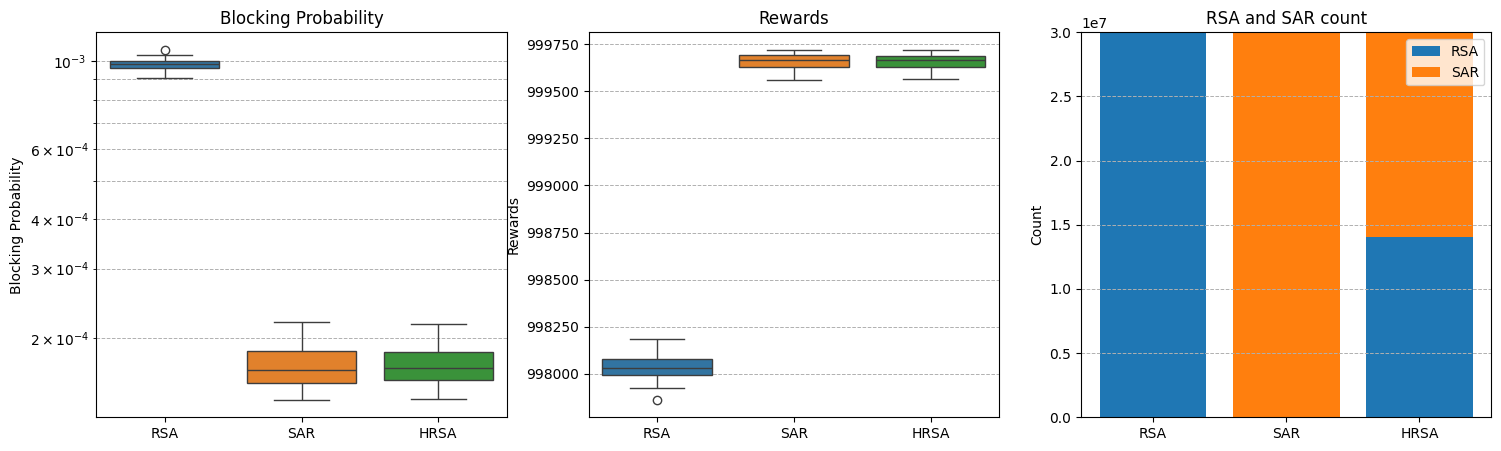

In [62]:
include_models(boxplot_data_240e)